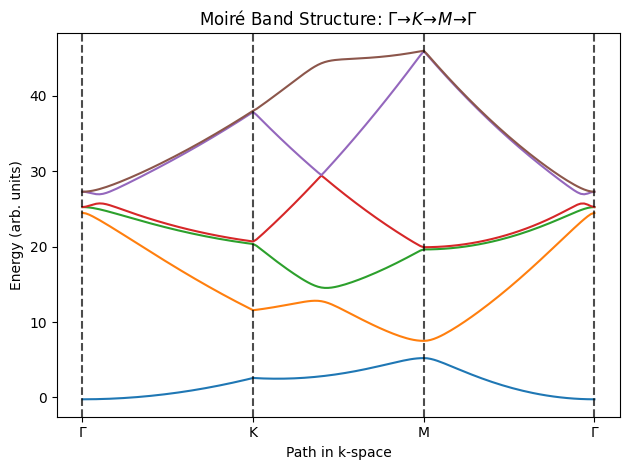

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# ----- Model parameters (match Script 1) -----
a_m = 1.0                 # moiré lattice constant (arb. units)
V0  = 1.0                 # potential strength (arb. units)
hbar2_over_2m = 0.5       # set ħ²/(2m)=½ to mirror Script 1

# ----- Build the same three moiré G-vectors -----
Gmag = 4 * np.pi / (np.sqrt(3) * a_m)
g1 = Gmag * np.array([np.cos(2*np.pi/3), np.sin(2*np.pi/3)])
g2 = Gmag * np.array([np.cos(4*np.pi/3), np.sin(4*np.pi/3)])
# (g3 is -g1-g2 but we only need g1,g2 to generate our G‐basis)

# ----- Plane-wave basis (square grid |n_i|≤3) -----
# Choose finite amount of {G} basis
Nmax = 3 
b1, b2 = g1, g2
G_list = []
idx_map = {}
for idx, (n1, n2) in enumerate([(i,j)
                                 for i in range(-Nmax, Nmax+1)
                                 for j in range(-Nmax, Nmax+1)]):
    G = n1*b1 + n2*b2
    G_list.append((n1, n2, G))
    idx_map[(n1,n2)] = idx
NG = len(G_list)

# ----- High-symmetry path Γ→K→M→Γ and k points -----
# building the sequence of crystal‐momenta {k} that we use to trace out 
# our band-structure plot Γ→K→M→Γ
Gamma = np.array([0.0, 0.0])  #center of Brillouin zone
K     = (b1 + b2)/3           # one of the hexagon corners
M     = b1/2                  # midpoint of an edge
path  = [Gamma, K, M, Gamma]
# split each segment into n_kseg points
n_kseg = 50
k_points = []
for P, Q in zip(path[:-1], path[1:]):
    # interpolate 50 evenly spaced k’s from starting point of segment to just before the ending point of that segment
    for t in np.linspace(0,1,n_kseg,endpoint=False):
        k_points.append(P + t*(Q-P))
k_points.append(path[-1])
num_k = len(k_points)

# ----- Precompute potential “shifts” -----
phi = 0.0
# since only non-zero off-diagonal terms are between G and G' that diff by +-g_j,
# (dn1, dn2, coeff) below:
# dn1, dn2, are shift in reciprical lattice index, or adding or substracting g_j, 
# and coeff are +-V_0 e^(+-phi) term in notes
shifts = [
    ( 1,  0, -V0 * np.exp( 1j*phi)),
    (-1,  0, -V0 * np.exp(-1j*phi)),
    ( 0,  1, -V0 * np.exp( 1j*phi)),
    ( 0, -1, -V0 * np.exp(-1j*phi)),
    (-1, -1, -V0 * np.exp( 1j*phi)),
    ( 1,  1, -V0 * np.exp(-1j*phi)),
]

# ----- Diagonalize and collect lowest 6 bands -----
num_bands = 6
bands = np.zeros((num_bands, num_k))

for ik, k in enumerate(k_points):
    # Hamiltonian matrix
    H = np.zeros((NG,NG), dtype=complex)
    # kinetic
    for i,(_,_,G) in enumerate(G_list):
        H[i,i] = hbar2_over_2m * np.dot(k+G, k+G)
    # potential
    for i,(n1,n2,_) in enumerate(G_list):
        for dn1,dn2,coeff in shifts:
            j = idx_map.get((n1+dn1, n2+dn2))
            if j is not None:
                H[i,j] += coeff
    # eigenvalues
    E = np.linalg.eigvalsh(H)
    bands[:,ik] = np.sort(E.real)[:num_bands]

# ----- Plot exactly as Script 1 -----
plt.figure()
for n in range(num_bands):
    plt.plot(bands[n])

ticks  = [0, n_kseg, 2*n_kseg, 3*n_kseg]
labels = ['$\\Gamma$', 'K', 'M', '$\\Gamma$']
for t in ticks:
    plt.axvline(t, color='k', linestyle='--', alpha=0.7)

plt.xticks(ticks, labels)
plt.xlabel('Path in k-space')
plt.ylabel('Energy (arb. units)')
plt.title('Moiré Band Structure: $\\Gamma\\!\\to\\!K\\!\\to\\!M\\!\\to\\!\\Gamma$')
plt.tight_layout()
plt.show()

In [29]:
from moire_model import energy_moire
from moire_model import coulomb_ewald_2D
from moire_model import moire_potential
# ----- Test the energy_moire function -----
np.random.seed(0)                       # Ensures same random number
R_config = np.random.rand(6,2) * a_m
energy_moire(R_config)

print("E_total_moire  =", energy_moire(R_config), "meV")
print('where:')
print("E_ee =", coulomb_ewald_2D(R_config), "meV")
print("E_ext =", np.sum(moire_potential(R_config)), "meV")

E_total_moire  = 307.3633819313337 meV
where:
E_ee = 77.04614228535969 meV
E_ext = 230.31723964597404 meV
